In [164]:
from sklearn.ensemble import GradientBoostingClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn import preprocessing
from imblearn.pipeline import Pipeline
from sklearn.metrics import roc_curve
from sklearn.metrics import f1_score
from xgboost import XGBClassifier
from sklearn.metrics import auc
import matplotlib.pyplot as plt
from datetime import datetime
from sklearn import tree
import lightgbm as lgb
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder

# %run /home/jovyan/work/riskModel/a0001/copy_0822/DataPrepare.ipynb

In [165]:
def grid_info(grid, m):
    """
    取得 grid search info

    :param grid: object, gird sarch
    :param m: string, model name
    :return: data.frame
    """

    df_info = pd.DataFrame(grid.cv_results_)
    df_info = df_info[['params', 'mean_test_score',
                       'rank_test_score']]
    df_info['model'] = m
    return df_info

In [166]:
def best_model(X, y, m=['tree', 'rf', 'adaboost', 'gbm'], m_params='', imbalance=False):
    """
    select best model

    :param X: data.frame/array, X
    :param y: data.frame/array, y
    :param m: list,, 待測試方法
                    'tree': decision tree
                    'rf': random forest
                    'xgb': xgb
    :return: model, cv result
    """

    # model method
    model_base = {

        "tree": {"model": tree.DecisionTreeClassifier(),
                 "params": {"step1": {'model__max_depth': [3, 5, 7]}}
                 },

        "rf": {"model": RandomForestClassifier(),
               "params": {"step1": {'model__max_depth': [3, 5, 7]}}
               },
        "adaboost":{"model": AdaBoostClassifier(),
                    "params": {"step1": {'model__n_estimators': [10, 30, 50],
                                         'model__learning_rate': [ 0.01, 0.1, 1]}}
               },
        "gbm":{"model": GradientBoostingClassifier(random_state=0),
               "params": {"step1": {'model__n_estimators': [10, 30, 50]},
                          "step2": {'model__max_depth': [3, 5]}}
               },
        "xgb": {"model": XGBClassifier(colsample_bytree=0.8,
                                       objective='binary:logistic',
                                       scale_pos_weight=1,
                                       eval_metric='error',
                                       use_label_encoder=False),
                "params": {'step1': {'model__max_depth': [3, 5, 7, 10],
                                     'model__min_child_weight': [1e-1, 1, 1e1]},
                           'step2': {'model__gamma': [0, 0.2]},
                           'step3': {'model__subsample': [0.8, 0.9]},
                           'step4': {'model__reg_alpha': [0, 1e-1, 1, 2]},
                           'step5': {'model__learning_rate': [0.1, 1]}}
                },
        "lgb": {"model": lgb.LGBMClassifier(),
                "params": {'step1': {'model__num_leaves': [5, 10, 20, 50]},
                           'step2': {'model__min_child_weight': [1e-1, 1, 1e1]},
                           'step3': {'model__subsample': [0.5, 0.8, 0.9, 1],
                                     'model__colsample_bytree': [0.5, 0.8, 0.9, 1]},
                           'step4': {'model__reg_alpha': [0, 1e-1, 1]}
                           }
                }
        
    }
    
    # set params
    if m_params == '':
        model_params = {your_key: model_base[your_key][
            'params'] for your_key in m}
    else:
        model_params = m_params

    # balance adjust
    if imbalance:
        model_pipe = [
            ('over', SMOTE(sampling_strategy=0.1)), ('under', RandomUnderSampler(sampling_strategy=0.5))]
    else:
        model_pipe = []
    
    md_dict, cv_result = {}, pd.DataFrame()
    for i in m:
        print("========== " + i + " Begin ==========")
        md = model_pipe + \
             [('model', model_base[i]['model'])]
        pipeline = Pipeline(steps=md)

        for step, param in model_params[i].items():
            # start time
            start = datetime.now()

            # grid search
            gs = GridSearchCV(estimator=pipeline,
                              param_grid=param,
                              scoring='roc_auc',
                              cv=3)
            gs.fit(X, y)
            # end time
            res = grid_info(gs, i)
            t = datetime.now()-start
            res['time'] = t
            # save
            cv_result = pd.concat([cv_result,
                                   res])

            # update
            pipeline.set_params(**gs.best_params_)
            print(step + ": ",
                  gs.best_params_, ", time:", t, "==========")

        md_dict[i] = pipeline
        print(i + " Done ==========")

    # select best
    cv_result.reset_index(drop=True, inplace=True)
    best_score = cv_result['mean_test_score'].max()
    best_res = cv_result[cv_result['mean_test_score'] == best_score]
    best_md_name = best_res.loc[best_res['time'].idxmin(), 'model']

    # fit best model
    best_e = md_dict[best_md_name]
    best_e.fit(X, y)
    
    # add all
    res = pd.concat(
        [cv_result,
         pd.DataFrame({'params': [best_e.get_params()],
                       'mean_test_score':[f1_score(y, best_e.predict(X), average='micro')],
                       'rank_test_score':['all'],
                       'model':[best_md_name]})])

    return best_e, res

In [167]:
def plot_importance(est, X):
    importances = est.get_params()['model'].feature_importances_
    feature_names = X.columns
    forest_importances = pd.Series(importances, index=feature_names)
    forest_importances = forest_importances.sort_values(ascending=True)

    fig, ax = plt.subplots()
    forest_importances.plot.barh()
    ax.set_title("Feature importances")
    ax.set_ylabel("Mean decrease in impurity")
    fig.tight_layout()

In [168]:
def plot_roc(est, x, y):
    # predict prob
    yhat = est.predict_proba(x)
    yhat = yhat[:, 1]
    
    # calculate roc
    fpr, tpr, thresholds= roc_curve(y, yhat)
    
    # gmean
    gmeans = np.sqrt(tpr * (1-fpr))
    ix = np.argmax(gmeans)
    print("Best Threshold=%f, g-means=%.3f" % (thresholds[ix], gmeans[ix]))
    
    # plot 
    plt.figure()
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.plot(fpr, tpr, marker='.', label='Model')
    #plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
    plt.title('ROC Curve')
    
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.show
    
    # sum 
    
    print('AUC:', auc(fpr, tpr))
    return thresholds[ix]
    

In [169]:
def model_info(y ,yhat):
    cm = confusion_matrix(y, yhat)
    print(cm)
    tot = sum(sum(cm))
    ac = (cm[0,0] + cm[1,1]) / tot
    sen = cm[1,1]/(cm[1,0]+cm[1,1])
    spe = cm[0,0]/(cm[0,0]+cm[0,1])
    
    print("Accuracy: ", ac,'\n',
          'Sensitivity: ', sen,'\n',
          'Specificity: ', spe,'\n',
          'Blance_Accuracy', (sen+spe)/2)
    

In [170]:
def model_report(X, y, est):
    y_pred = est.predict(X)
    print(classification_report(y, y_pred))

In [171]:
def model_process(train_x, train_y, test_x, test_y, m=['tree', 'rf', 'adaboost', 'gbm'], roc=True, m_params='', imbalance=False):
    
    plt.rcParams['figure.figsize'] = [12, 6]
    print("==================== Training Begin ====================")
    
    # fit model
    est, cv_report = best_model(train_x, train_y, m=m, m_params=m_params, imbalance=imbalance)
    print("==================== Training End ====================")

    if roc:
        # roc plot
        print("Training ROC ====================")
        best_train = plot_roc(est, train_x, train_y)
        
        print("Test ROC ====================")
        best_test = plot_roc(est, test_x, test_y)
        
        # predict
        train_yhat = est.predict_proba(train_x)[:, 1]
        train_yhat = np.where(train_yhat>=best_train, 1, 0)
    
        test_yhat = est.predict_proba(test_x)[:, 1]
        test_yhat = np.where(test_yhat>=best_train, 1, 0)
    else:
        best_train = 0.5
        train_yhat = est.predict(train_x)
        test_yhat = est.predict(test_x)

    
    print("==================== Model info ====================")    
    print('Best Model: ' + cv_report[cv_report['rank_test_score']=='all']['model'][0])
        
    # plot importance
    plot_importance(est, train_x)
        
    # train report
    print("Training Data: ")
    model_info(train_y, train_yhat)
    print(classification_report(train_y, train_yhat))

    # test data
    print("Testing Data: ")
    model_info(test_y, test_yhat)
    print(classification_report(test_y, test_yhat))

    return est, cv_report, train_yhat, best_train

In [172]:
def clean_process(df, model_params):
    # to numeric
    print('to Numeric:')
    for i in model_params['numeric_col']:
        df[i] = pd.to_numeric(df[i])
        print(i + ' ok')

    # to ordinal
    print('to Ordinal:')
    for i in model_params['ordinal']:
        df[i] = df[i].astype(str)
        le = preprocessing.LabelEncoder()
        le.fit(df[i])
        df[i] = le.transform(df[i])
        print(i + ' ok')
    
    return df

In [180]:
# todo: merge dtid 
dt = pd.read_csv(f"/home/jovyan/work/riskModel/a0001/copy_0822/prepare_data/training.csv")
dt = dt[dt.columns[~dt.columns.isin(['id','AGE','index_date','AGE_n_last','SUICIDEREASON_last',
                                     'BEHAVIOR_CD_last'])]]
dt['event'] = dt['event'].map({'case':1,'control':0})

encoder = LabelEncoder()
dt[dt.columns] = dt[dt.columns].apply(encoder.fit_transform)
dt = dt.apply(lambda x: x.astype('category'))

print(dt.dtypes)

id                                      category
index_date                              category
event                                   category
index_year_180                          category
RDATE_year                              category
                                          ...   
CNDT5_OUT_MK_last                       category
NOTICE_TIME_TRANSFER_NORMAL_id_exist    category
AcceptCaseDate_id_exist                 category
NOTICE_TIME_NOTICE_id_exist             category
n                                       category
Length: 68, dtype: object


In [175]:
x_train = dt[(dt['train_test']==1)][dt.columns[~dt.columns.isin(["event",'train_test','n'])]]
y_train = dt[dt['train_test']==1]['event']
x_test = dt[(dt['train_test']==0)][dt.columns[~dt.columns.isin(["event",'train_test','n'])]]
y_test = dt[dt['train_test']==0]['event']

==================== Training Begin ====================
========== tree Begin ==========


/opt/conda/lib/python3.10/site-packages/xgboost/sklearn.py:1421: UserWarning: `use_label_encoder` is deprecated in 1.7.0.
  warnings.warn("`use_label_encoder` is deprecated in 1.7.0.")


step1:  {'model__max_depth': 5} , time: 0:00:03.586978 ==========
tree Done ==========
========== rf Begin ==========
step1:  {'model__max_depth': 5} , time: 0:00:08.849126 ==========
rf Done ==========
==================== Training End ====================
Training ROC ====================
Best Threshold=0.709591, g-means=0.739
AUC: 0.81899876775131
Test ROC ====================
Best Threshold=0.697219, g-means=0.737
AUC: 0.8178258385181081
==================== Model info ====================
Best Model: rf
Training Data: 
[[ 1985   598]
 [20511 50184]]
Accuracy:  0.7119326400829717 
 Sensitivity:  0.7098663271801401 
 Specificity:  0.7684862562911343 
 Blance_Accuracy 0.7391762917356373
              precision    recall  f1-score   support

           0       0.09      0.77      0.16      2583
           1       0.99      0.71      0.83     70695

    accuracy                           0.71     73278
   macro avg       0.54      0.74      0.49     73278
weighted avg       0.96      0

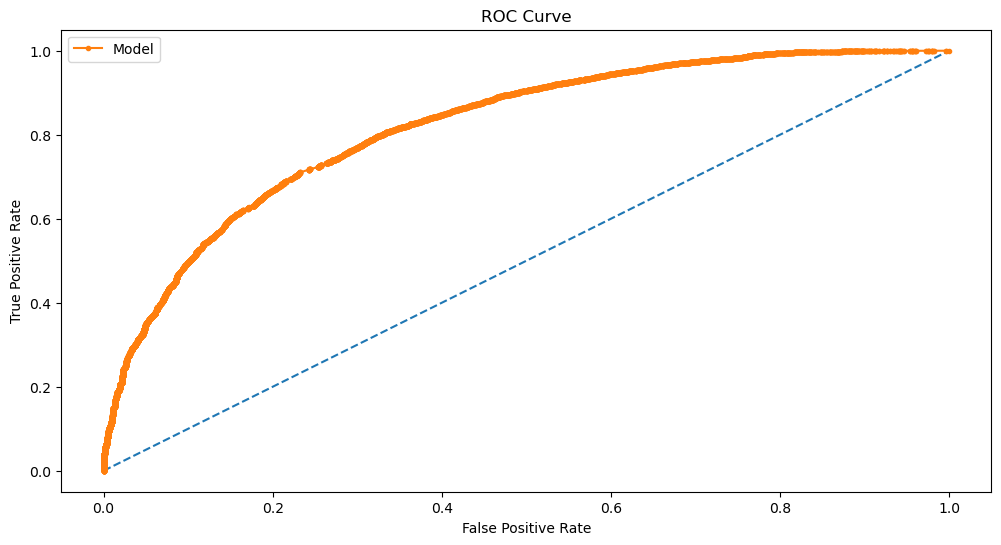

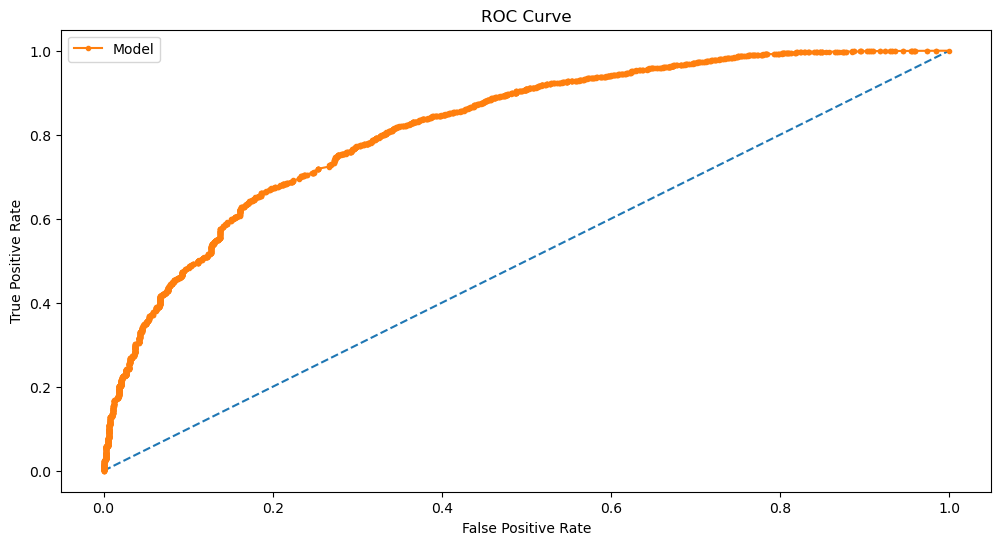

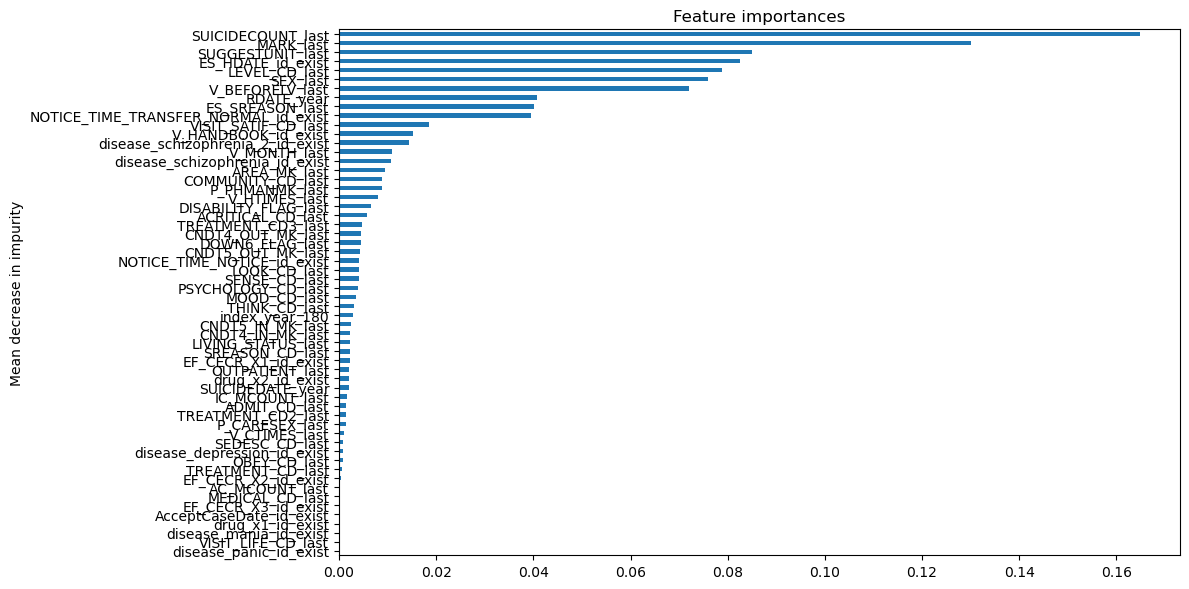

In [176]:
est, cv_report, train_yhat, best_train = model_process(train_x=x_train,
                                                       train_y=y_train,
                                                       test_x=x_test,
                                                       test_y=y_test,
                                                       m=['tree', 'rf'],
                                                       imbalance=True)